# Modelado

EXTRATEGIA QUE SE HA DECIDIDO SEGUIR:

In [1]:
# Librerías básicas
import numpy as np
import pandas as pd
import os
import joblib

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Métodos de validación y ajuste de modelos
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scipy.stats import randint, uniform


# Modelos de regresión
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
import xgboost as xgb
from sklearn.svm import LinearSVR
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# SHAP para explicación de modelos
import shap
shap.initjs()

# Importación de módulos personalizados
from modulos.data_description import *
from modulos.data_model import *
from modulos.data_visualization import *

# Configuración de pandas
pd.set_option('display.max_columns', None)

In [ ]:
def seleccionar_alpha_optimo(rmse_cv, rmse_sd, alphas):
    """ 
    Selecciona el valor óptimo de alpha para regularización usando la regla del mínimo 
    más una desviación estándar.

    Parámetros:
    rmse_cv (numpy array): Array con los valores de RMSE obtenidos en validación cruzada.
    rmse_sd (numpy array): Array con las desviaciones estándar del RMSE para cada alpha.
    alphas (numpy array): Array con los valores de alpha evaluados.

    Resultado:
    tuple: (alpha óptimo, alpha óptimo con la regla de 1 desviación estándar)
    """
    
    # Encuentra el valor mínimo de RMSE en validación cruzada
    min_rmse = np.min(rmse_cv)

    # Obtiene la desviación estándar asociada al mínimo RMSE
    sd_min_rmse = rmse_sd[np.argmin(rmse_cv)]

    # Calcula el umbral del mínimo RMSE + 1 desviación estándar
    min_rmse_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])

    # Alpha correspondiente al RMSE mínimo
    optimo = alphas[np.argmin(rmse_cv)]

    # Alpha más pequeño cuyo RMSE esté dentro del umbral mínimo + 1 desviación estándar
    optimo_1sd = alphas[rmse_cv == min_rmse_1sd][0]

    return optimo, optimo_1sd

In [ ]:
def graficar_evolucion_coeficientes(alphas, coefs, modelo):
    """
    Grafica la evolución de los coeficientes en función de alpha.

    Parámetros:
    -----------
    alphas : array-like
        Valores de regularización alpha.

    coefs : array-like
        Coeficientes del modelo para cada alpha.

    modelo : object
        Modelo ajustado, cuyo nombre se extraerá automáticamente.

    """
    fig, ax = plt.subplots(figsize=(7, 3.84))
    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    ax.set_xlabel('alpha')
    ax.set_ylabel('coeficientes')
    ax.set_title(f'Evolución de coeficientes - {modelo.__class__.__name__}')
    plt.axis('tight')

In [ ]:
def graficar_coeficientes(modelo, X_train):
    """
    Grafica los coeficientes del modelo ajustado, excluyendo los coeficientes igual a 0 en modelos como Lasso y ElasticNet.
    
    Parámetros:
    modelo : object
        Modelo ajustado con el atributo `coef_`.
    X_train : pandas.DataFrame
        Datos de entrada que fueron usados para entrenar el modelo.
    titulo : str
        Título para la gráfica.
    """
    # Filtrar coeficientes no nulos en Lasso y ElasticNet
    df_coeficientes = pd.DataFrame({
        'predictor': X_train.columns,
        'coef': modelo.coef_.flatten()
    })
    
    # Filtrar coeficientes que son distintos de 0
    df_coeficientes = df_coeficientes[df_coeficientes.coef != 0]
    
    fig, ax = plt.subplots(figsize=(11, 3.84))
    ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
    plt.xticks(rotation=90, ha='right', size=5)
    ax.set_xlabel('variable')
    ax.set_ylabel('coeficientes')
    ax.set_title(f"Coeficientes del modelo: {modelo.__class__.__name__}")

In [3]:
def pred_vs_real(model, X_test, y_test):
    """
    Compara la predicción del modelo con el valor real para una muestra.

    Parámetros:
    model: Modelo entrenado.
    X_test: Datos de prueba (características).
    y_test: Datos de prueba (valores reales).

    Resultado:
    Muestra la predicción del modelo y el valor real correspondiente.
    """
    # Obtener la predicción del modelo para la misma muestra
    prediccion = model.predict(X_test.iloc[0:1, :])[0]
    
    # Obtener el valor real de la muestra
    valor_real = y_test.iloc[0]

    # Mostrar la comparación
    print(f"Predicción del modelo: {prediccion}")
    print(f"Valor real: {valor_real}")

## 1. Carga del Dataset

In [4]:
# Cargamos el dataset internal_transformed
ruta_binario = os.path.join('data', 'internal_transformed.pkl')
internal_transformed = joblib.load(ruta_binario)

# Eliminamos la variable 'Credit_Score' para que no esté duplicada
internal_transformed.drop(columns='Credit_Score', inplace=True)

In [5]:
# Cargamos el dataset external_transformed
ruta_binario = os.path.join('data', 'external_transformed.pkl')
external_transformed = joblib.load(ruta_binario)

### Unión ambos Dataset

In [ ]:
# Fusión de DataFrames por PROSPECTID  
df = pd.merge(internal_transformed, external_transformed, on=['PROSPECTID'], how='inner')

### División del Dataset

In [7]:
# Separamos variable dependiente de las independientes
X = df.drop(columns=['Credit_Score', 'PROSPECTID'], inplace=False)
Y = df['Credit_Score']

# Generamos el dataset de entrenamiento y el de test
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=29, shuffle=True)

## 2. Regularización (Ridge, Lasso, ElasticNet)

### 2.1. Linear Regression

In [ ]:
# Entrenamiento del modelo de regresión lineal  
linear = LinearRegression(fit_intercept=False)
linear.fit(X_train, y_train)

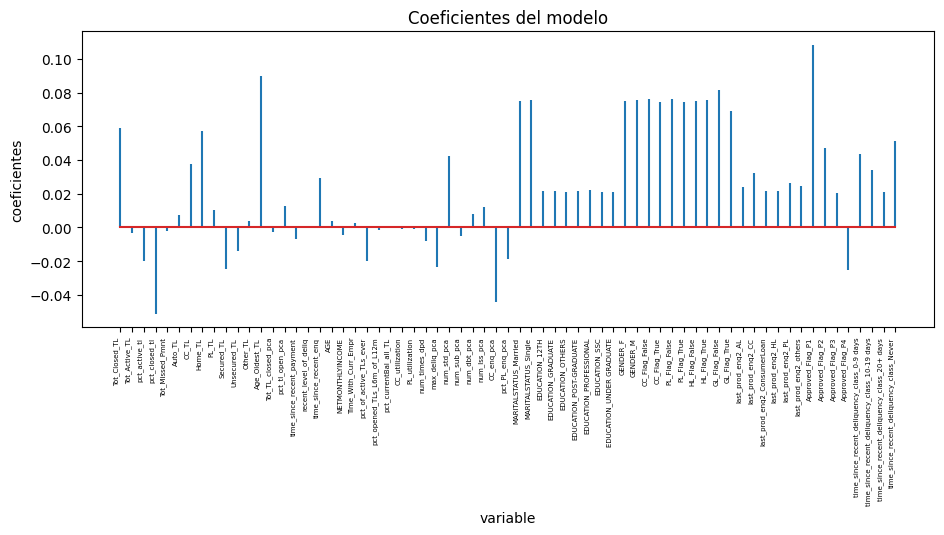

In [ ]:
# Gráfico de los coeficientes del modelo  
graficar_coeficientes(linear, X_train)


In [ ]:
# Predicción del modelo sobre el conjunto de test  
y_pred = linear.predict(X_test).flatten()

# Cálculo del error RMSE  
rmse_linear = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))

# Impresión del error RMSE  
print(f"El error (rmse) de test es: {rmse_linear}")

El error (rmse) de test es: 0.02697511005127307


### 2.2. Ridge

In [ ]:
# Entrenamiento del modelo Ridge con validación cruzada
modelo_ridge = RidgeCV(
    alphas=np.logspace(-3, 10, 200),
    store_cv_values=True,
    fit_intercept=False
).fit(X_train, y_train)

C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


(np.float64(0.000223872113856834),
 np.float64(44668359215.09635),
 np.float64(-0.05909234757802006),
 np.float64(0.11629296923753787))

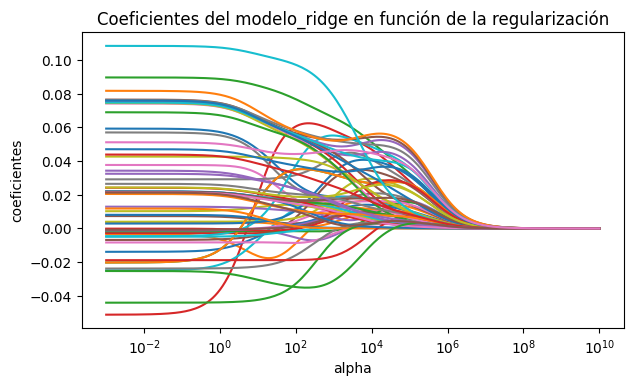

In [ ]:
# Evolución de los coeficientes en función de alpha
alphas = modelo_ridge.alphas
coefs = []

# Cálculo de los coeficientes para diferentes valores de alpha
for alpha in alphas:
    modelo_ridge_temp = Ridge(alpha=alpha, fit_intercept=False)
    modelo_ridge_temp.fit(X_train, y_train)
    coefs.append(modelo_ridge_temp.coef_.flatten())

# Gráfico de la evolución de los coeficientes
graficar_evolucion_coeficientes(alphas, coefs, modelo_ridge)

C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


Mejor valor de alpha encontrado: 0.10595601792776159
Mejor valor de alpha encontrado + 1 desviación estándar: 37834.62617131933


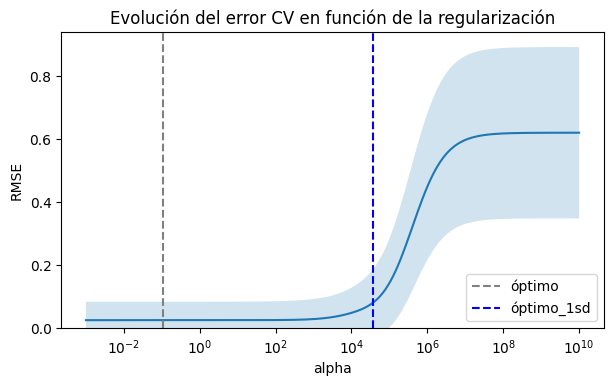

In [ ]:
# Cálculo del error medio cuadrático (MSE) y desviación estándar en validación cruzada
mse_cv = modelo_ridge.cv_values_.mean(axis=0)
mse_sd = modelo_ridge.cv_values_.std(axis=0)

# Cálculo del error cuadrático medio (RMSE) y su desviación estándar
rmse_cv, rmse_sd = np.sqrt(mse_cv), np.sqrt(mse_sd)

# Selección del mejor valor de alpha y el valor de alpha + 1 desviación estándar
optimo_ridge, optimo_ridge_1sd = seleccionar_alpha_optimo(rmse_cv, rmse_sd, modelo_ridge.alphas)

# Gráfico del error con intervalo de +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo_ridge.alphas, rmse_cv)
ax.fill_between(
    modelo_ridge.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

# Líneas verticales indicando los valores óptimos de alpha
ax.axvline(
    x         = optimo_ridge,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_ridge_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

# Ajustes de la visualización
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend()

# Impresión de los mejores valores de alpha encontrados
print(f"Mejor valor de alpha encontrado: {modelo_ridge.alpha_}")
print(f"Mejor valor de alpha encontrado + 1 desviación estándar: {optimo_ridge_1sd}")

In [ ]:
# Entrenamiento del modelo Ridge final con el alpha seleccionado
modelo_ridge_final = Ridge(alpha=optimo_ridge_1sd, fit_intercept=False).fit(X_train, y_train)

# Predicción del modelo sobre el conjunto de test
y_pred_ridge = modelo_ridge_final.predict(X_test)

# Cálculo del error RMSE para el modelo Ridge final
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

# Impresión del RMSE obtenido
print(f"RMSE Ridge: {rmse_ridge}")

RMSE Ridge: 0.08256464262034496


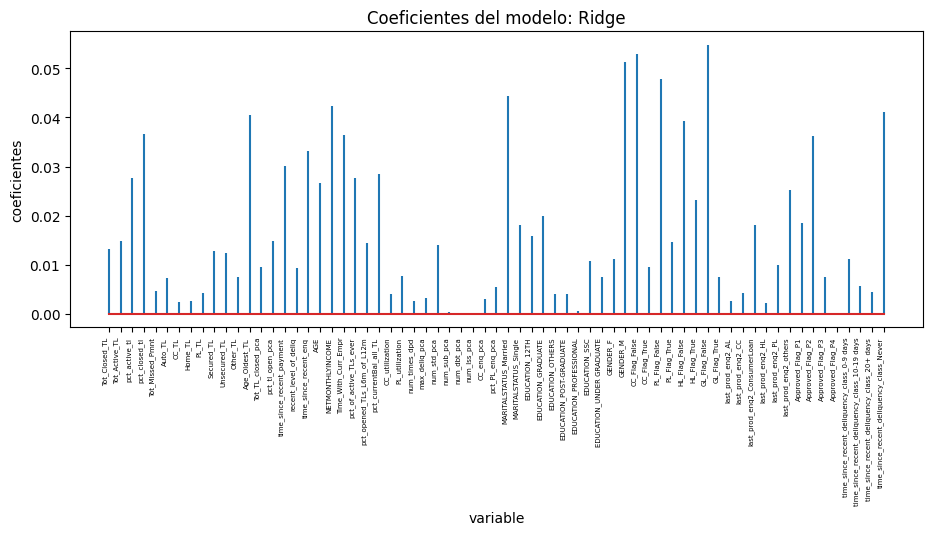

In [ ]:
# Gráfico de los coeficientes del modelo  
graficar_coeficientes(modelo_ridge_final, X_train)

### 2.3. Lasso

In [ ]:
# Entrenamiento del modelo Lasso con validación cruzada
modelo_lasso = LassoCV(
    alphas=np.logspace(-7, 3, 200),  # Rango de alphas evaluados
    cv=5,  # Número de pliegues para validación cruzada
    fit_intercept=False  # No incluye el término de intersección
).fit(X_train, y_train)

C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5478305903440592, tolerance: 1.2612243057692962
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.510631764542792, tolerance: 1.2612243057692962
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:

C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e+00, tolerance: 1.576e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.242e+00, tolerance: 1.576e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8

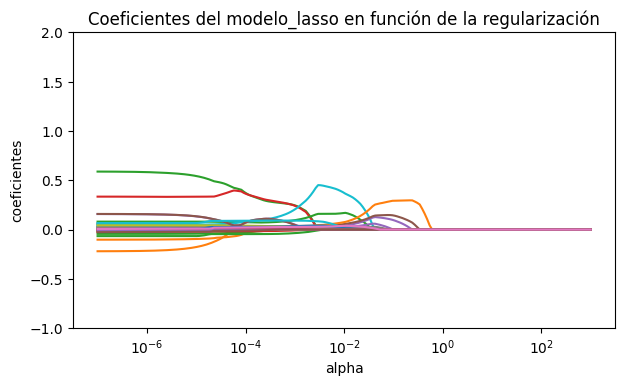

In [ ]:
# Evolución de los coeficientes en función de alpha
alphas = modelo_lasso.alphas_
coefs = []

# Cálculo de los coeficientes para diferentes valores de alpha
for alpha in alphas:
    modelo_lasso_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_lasso_temp.fit(X_train, y_train)
    coefs.append(modelo_lasso_temp.coef_.flatten())

# Gráfico de la evolución de los coeficientes
graficar_evolucion_coeficientes(alphas, coefs, modelo_lasso)

Mejor valor de alpha encontrado: 1e-07
Mejor valor de alpha encontrado + 1 desviación estándar: 0.00148202070579886


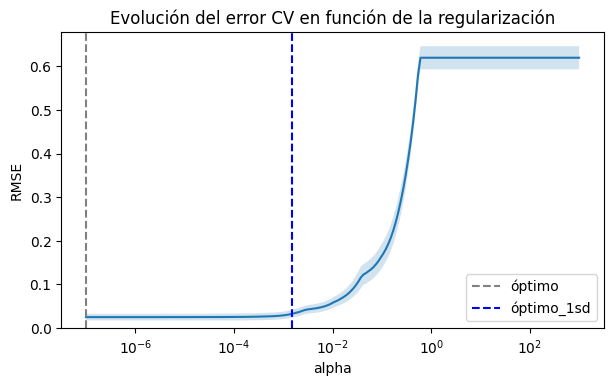

In [17]:
# Cálculo del error medio cuadrático (MSE) y desviación estándar en validación cruzada
mse_cv = modelo_lasso.mse_path_.mean(axis=1)
mse_sd = modelo_lasso.mse_path_.std(axis=1)

# Cálculo del error cuadrático medio (RMSE) y su desviación estándar
rmse_cv, rmse_sd = np.sqrt(mse_cv), np.sqrt(mse_sd)

# Selección del mejor valor de alpha y el valor de alpha + 1 desviación estándar
optimo_lasso, optimo_lasso_1sd = seleccionar_alpha_optimo(rmse_cv, rmse_sd, modelo_lasso.alphas_)

# Gráfico del error con intervalo de +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo_lasso.alphas_, rmse_cv)
ax.fill_between(
    modelo_lasso.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

# Líneas verticales indicando los valores óptimos de alpha
ax.axvline(
    x         = optimo_lasso,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_lasso_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

# Ajustes de la visualización
ax.set_xscale('log')
ax.set_ylim([0, None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend()

# Impresión de los mejores valores de alpha encontrados
print(f"Mejor valor de alpha encontrado: {modelo_lasso.alpha_}")
print(f"Mejor valor de alpha encontrado + 1 desviación estándar: {optimo_lasso_1sd}")

In [18]:
# Entrenamiento del modelo Lasso final con el alpha seleccionado
modelo_lasso_final = Lasso(alpha=optimo_lasso_1sd, fit_intercept=False).fit(X_train, y_train)

# Predicción del modelo sobre el conjunto de test
y_pred_lasso = modelo_lasso_final.predict(X_test)

# Cálculo del error RMSE para el modelo Lasso final
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

# Impresión del RMSE obtenido
print(f"RMSE Lasso: {rmse_lasso}")

RMSE Lasso: 0.03458016340766251


In [ ]:
# Gráfico de los coeficientes del modelo  
graficar_coeficientes(modelo_lasso_final, X_train)

predictor      coef
2                                 pct_active_tl  0.204151
3                                 pct_closed_tl  0.194994
12                                Age_Oldest_TL  0.111568
17                        time_since_recent_enq  0.037211
19                             NETMONTHLYINCOME  0.270991
20                          Time_With_Curr_Empr  0.013171
21                       pct_of_active_TLs_ever  0.000485
23                        pct_currentBal_all_TL  0.007453
28                                  num_std_pca  0.021244
33                               pct_PL_enq_pca -0.003974
34                        MARITALSTATUS_Married  0.018380
35                         MARITALSTATUS_Single  0.012815
43                                     GENDER_F  0.000092
44                                     GENDER_M  0.008804
45                                CC_Flag_False  0.021688
46                                 CC_Flag_True  0.000042
47                                PL_Flag_False  0.012736
48                                 PL_Flag_True  0.000061
49                                HL_Flag_False  0.001797
50                                 HL_Flag_True  0.000003
51                                GL_Flag_False  0.022907
58                        last_prod_enq2_others  0.001126
59                             Approved_Flag_P1  0.089985
60                             Approved_Flag_P2  0.035734
62                             Approved_Flag_P4 -0.029309
63  time_since_recent_deliquency_class_0-9 days  0.005882
66     time_since_recent_deliquency_class_Never  0.027389

Text(0.5, 1.0, 'Coeficientes del modelo')

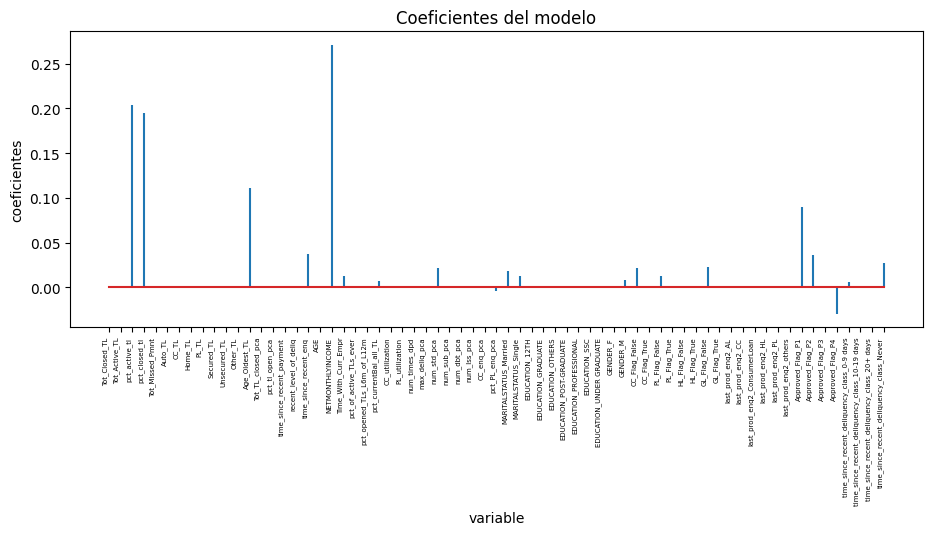

In [20]:
# Gráfico de los coeficientes del modelo Lasso final
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo')

### 2.4. Elastic Net

In [21]:
# ElasticNetCV - Ajuste y selección de alpha óptimo
modelo_elastic = ElasticNetCV(
    l1_ratio=[0, 0.1, 0.4, 0.5, 0.7, 0.9, 0.99],
    alphas=np.logspace(-8, 3, 200),
    cv=5,
    fit_intercept=False
).fit(X_train, y_train)

C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6247.707163787179, tolerance: 1.2612243057692962
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWar

In [ ]:
# Evolución de los coeficientes en función de alpha
alphas = modelo_elastic.alphas
coefs = []

# Cálculo de los coeficientes para diferentes valores de alpha
for alpha in alphas:
    modelo_elastic_temp = ElasticNet(alpha=alpha, fit_intercept=False)
    modelo_elastic_temp.fit(X_train, y_train)
    coefs.append(modelo_elastic_temp.coef_.flatten())
    
# Gráfico de la evolución de los coeficientes
graficar_evolucion_coeficientes(alphas, coefs, modelo_elastic)


In [24]:
# Cálculo del error medio cuadrático (MSE) y desviación estándar en validación cruzada
mse_cv = modelo_elastic.mse_path_.mean(axis=2)
mse_sd = modelo_elastic.mse_path_.std(axis=2)

# Cálculo del error cuadrático medio (RMSE) y su desviación estándar
rmse_cv, rmse_sd = np.sqrt(mse_cv), np.sqrt(mse_sd)

# Selección de los índices óptimos para el mejor valor de L1 y alpha
best_l1_idx, best_alpha_idx = np.unravel_index(np.argmin(rmse_cv), rmse_cv.shape)

# Selección del mejor valor de alpha y el valor de alpha + 1 desviación estándar
optimo_elastic, optimo_elastic_1sd = seleccionar_alpha_optimo(
    rmse_cv[best_l1_idx, :], rmse_sd[best_l1_idx, :], modelo_elastic.alphas_)

In [25]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio
mean_error_cv = modelo_elastic.mse_path_.mean(axis=2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha), se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [modelo_elastic.l1_ratio, modelo_elastic.alphas_],
                                    names     = ['l1_ratio', 'modelo_elastic.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

# Cálculo del RMSE a partir del MSE
df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])

# Ordenación de los resultados por MSE en orden ascendente
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending=True)

# Visualización del dataframe con los resultados
df_resultados_cv

l1_ratio  modelo_elastic.alphas_    mse_cv   rmse_cv
575        0.4            2.121452e-07  0.000636  0.025228
776        0.5            1.867914e-07  0.000636  0.025228
777        0.5            1.644676e-07  0.000636  0.025228
979        0.7            1.275051e-07  0.000636  0.025228
1181       0.9            9.884959e-08  0.000636  0.025228
...        ...                     ...       ...       ...
649        0.5            1.956398e+00  0.383779  0.619499
650        0.5            1.722586e+00  0.383779  0.619499
651        0.5            1.516717e+00  0.383779  0.619499
652        0.5            1.335452e+00  0.383779  0.619499
653        0.5            1.175850e+00  0.383779  0.619499

[1400 rows x 4 columns]

In [26]:
# Impresión del mejor valor de alpha y l1_ratio encontrados
print(f"Mejor valor de alpha encontrado: {modelo_elastic.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo_elastic.l1_ratio_}")

Mejor valor de alpha encontrado: 2.1214517849106278e-07
Mejor valor de l1_ratio encontrado: 0.4


In [27]:
# Ajuste del modelo ElasticNet final con el valor óptimo de alpha
modelo_elastic_final = ElasticNet(alpha=optimo_elastic_1sd, fit_intercept=False).fit(X_train, y_train)

# Predicción con el modelo ajustado
y_pred_elastic = modelo_elastic_final.predict(X_test)

# Cálculo del RMSE para el modelo ElasticNet
rmse_elastic = np.sqrt(mean_squared_error(y_test, y_pred_elastic))

# Impresión del RMSE
print(f"RMSE Elastic Net: {rmse_elastic}")

RMSE Elastic Net: 0.036228931372460166


Text(0, 0.5, 'rmse_cv')

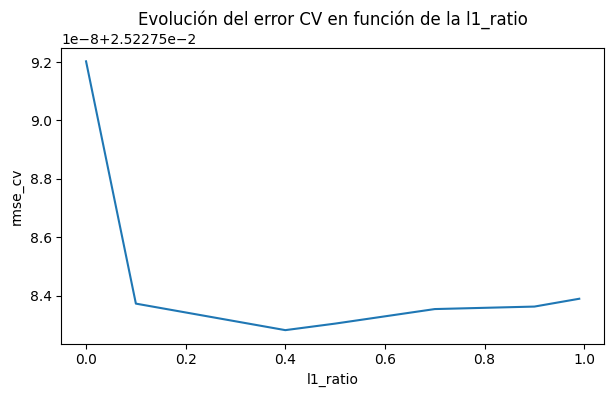

In [ ]:
# Mejor valor encontrado para cada l1_ratio
fig, ax = plt.subplots(figsize=(7, 3.84))

# Graficar el mejor valor de RMSE para cada l1_ratio
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax=ax)

# Configuración del gráfico
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

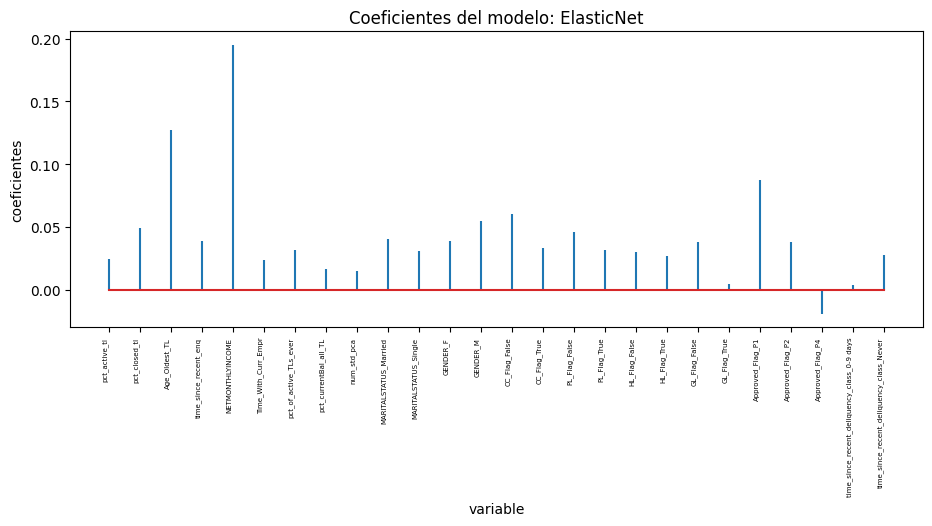

In [ ]:
# Gráfico de los coeficientes del modelo  
graficar_coeficientes(modelo_elastic_final, X_train)

Text(0.5, 1.0, 'Coeficientes del modelo')

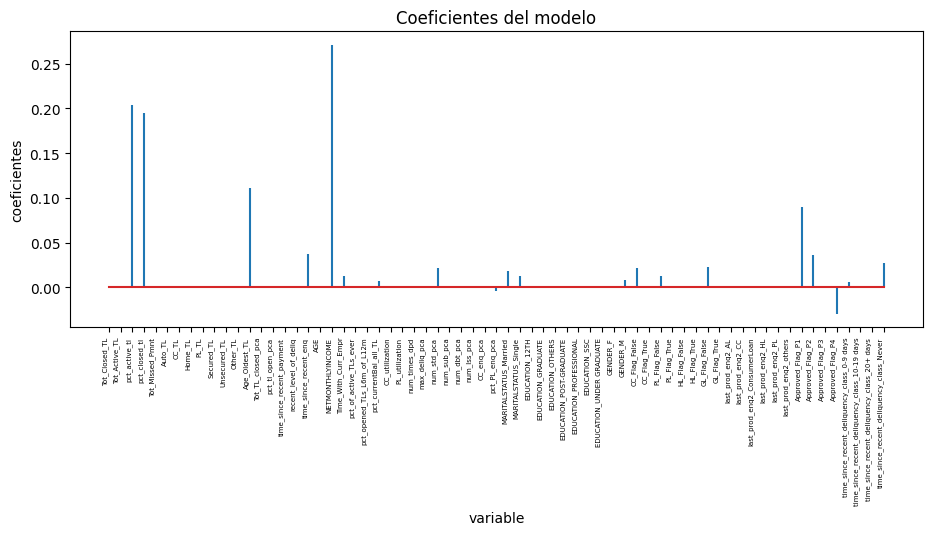

In [ ]:
# Gráfico de los coeficientes del modelo
fig, ax = plt.subplots(figsize=(11, 3.84))

# Representación gráfica de los coeficientes
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')

# Configuración del gráfico
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

### 2.5. Comparación

Text(0.5, 1.0, 'Comparación de modelos')

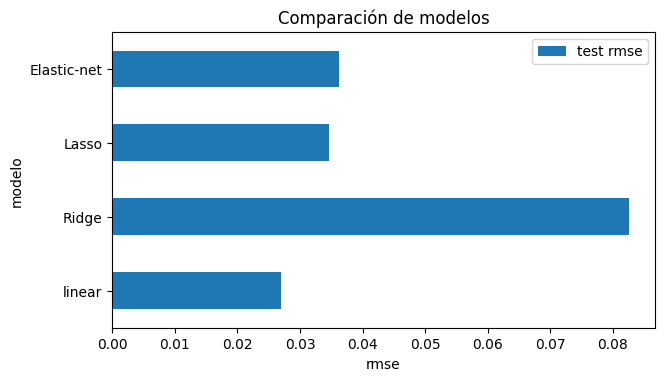

In [ ]:
# Comparación de modelos
df_comparacion = pd.DataFrame({
                    'modelo': ['linear', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_linear, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

# Gráfico de comparación de modelos
fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)

# Configuración del gráfico
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');

## 3. Regresión Lineal 

In [34]:
# Crear el explicador de SHAP para el mejor modelo de regresión lineal
explainer = shap.LinearExplainer(
    model=linear, 
    masker=shap.maskers.Independent(X_train),
    feature_perturbation='interventional')

# Obtener los valores SHAP para todo el conjunto de prueba
shap_values = explainer.shap_values(X_test)

# Imprimimos las características de los SHAP values por unica vez
print(f'Forma del conjunto de datos de prueba: {X_test.shape}')
print(f'Tipo de shap_values: {type(shap_values)}. Longitud de la lista: {len(shap_values)}')
print(f'Forma de shap_values: {np.array(shap_values).shape}')

Forma del conjunto de datos de prueba: (10268, 67)
Tipo de shap_values: <class 'numpy.ndarray'>. Longitud de la lista: 10268
Forma de shap_values: (10268, 67)


C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [35]:
# Explicamos la influencia de los valores SHAP para una predicción
shap.force_plot(explainer.expected_value, shap_values[0, :], features=X_test.iloc[0, :])

In [36]:
# Explicación de predicciones para más de una muestra
shap.force_plot(explainer.expected_value, shap_values[:100, :], features=X_test.iloc[:100, :])

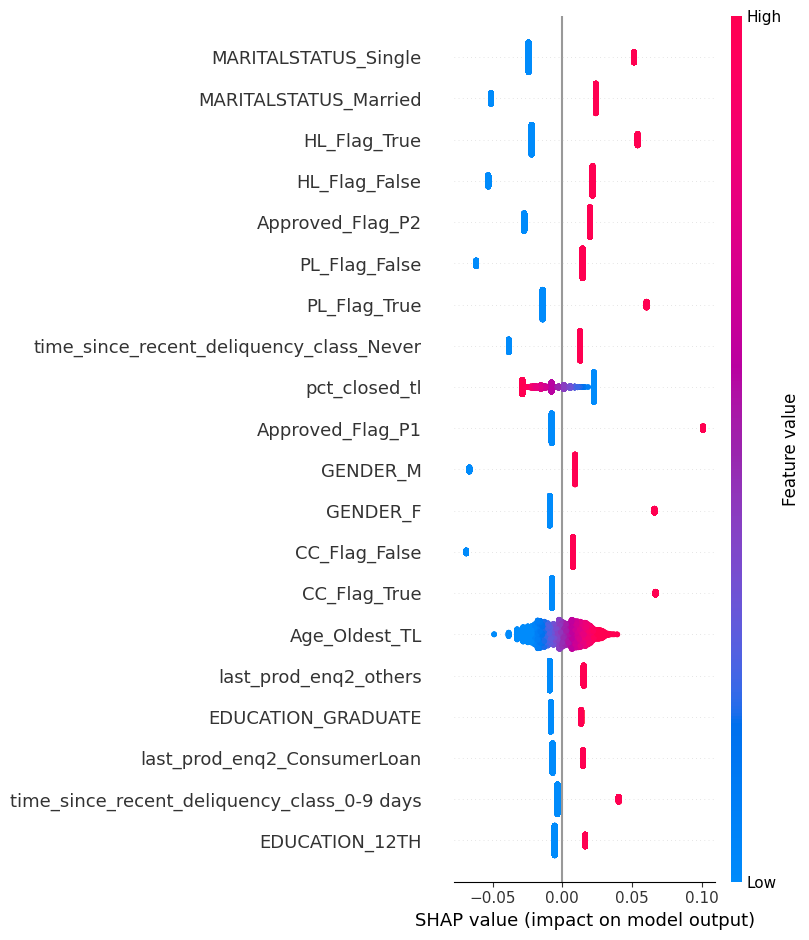

In [37]:
# Visualizar la importancia de las características
shap.summary_plot(shap_values, X_test)

In [38]:
pred_vs_real(linear, X_test, y_test)

Predicción del modelo: 0.7231145856503138
Valor real: 0.7222222222222223


In [39]:
# Calcular RMSE y R² en el conjunto de prueba
predicciones_test = linear.predict(X_test)
mse_linear = mean_squared_error(y_test, predicciones_test)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, predicciones_test)

# Imprimir las métricas
print(f"RMSE: {rmse_linear}")
print(f"R²: {r2_linear}")

RMSE: 0.02697511005127307
R²: 0.806308039596342


## 4. K-Nearest Neighbours (KNN)

In [40]:
# Definir el rango de valores de k a evaluar
param_grid = {'n_neighbors': range(1, 30)}

# Crear el modelo kNN para regresión
knn = KNeighborsRegressor()

# Configurar GridSearchCV con validación cruzada de 5 folds
grid_search = GridSearchCV(
    knn, 
    param_grid, 
    cv=5, 
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    n_jobs=-1
)

# Ajustar el modelo en los datos de entrenamiento
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 30)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'))

In [41]:
# Obtener el mejor modelo entrenado tras la búsqueda de hiperparámetros
best_knn = grid_search.best_estimator_

# Obtener el mejor valor de k
best_k = grid_search.best_params_['n_neighbors']
print(f"Mejor valor de k: {best_k}")

Mejor valor de k: 16


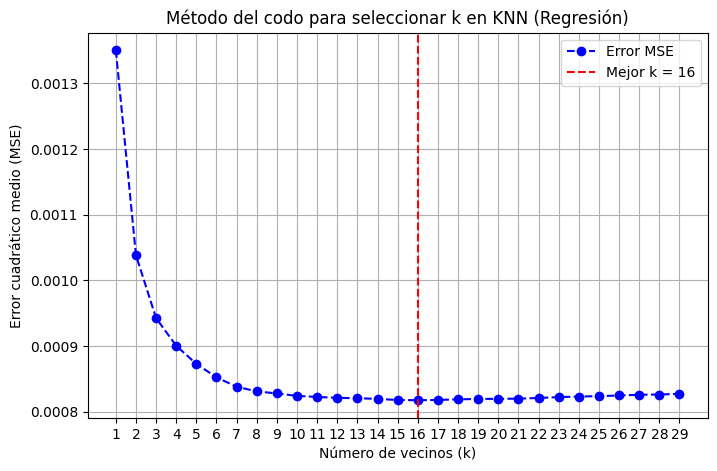

In [42]:
# Obtener la evolución del error en función de k
k_values = param_grid['n_neighbors']
errors = -grid_search.cv_results_['mean_test_score']

# Graficar la evolución del error (Método del Codo)
plt.figure(figsize=(8, 5))
plt.plot(k_values, errors, marker='o', linestyle='dashed', color='b', label="Error MSE")
plt.axvline(best_k, linestyle="--", color="r", label=f"Mejor k = {best_k}")
plt.xlabel("Número de vecinos (k)")
plt.ylabel("Error cuadrático medio (MSE)")
plt.title("Método del codo para seleccionar k en KNN (Regresión)")
plt.xticks(k_values)
plt.legend()
plt.grid()

In [53]:
# Usar K-Means para agrupar y reducir los datos de referencia a 50 centroides
background_kmeans = shap.kmeans(X_train, 50)
background_kmeans_array = np.array(background_kmeans.data)

# Crear el explicador con el conjunto reducido
explainer = shap.KernelExplainer(
    model=best_knn.predict,
    data=background_kmeans_array,
    masker=shap.maskers.Independent(background_kmeans_array)  # <-- Aquí está el cambio
)

# Obtener valores SHAP para las primeras 10 muestras de prueba
shap_values = explainer.shap_values(X_test.iloc[0:10, :])

  0%|          | 0/10 [00:00<?, ?it/s]

In [54]:
# Explicamos la influencia de los valores SHAP para una predicción
shap.force_plot(explainer.expected_value, shap_values[0, :], features=X_test.iloc[0, :])

In [55]:
# Explicación de predicciones para más de una muestra
shap.force_plot(explainer.expected_value, shap_values[:100, :], features=X_test.iloc[:100, :])

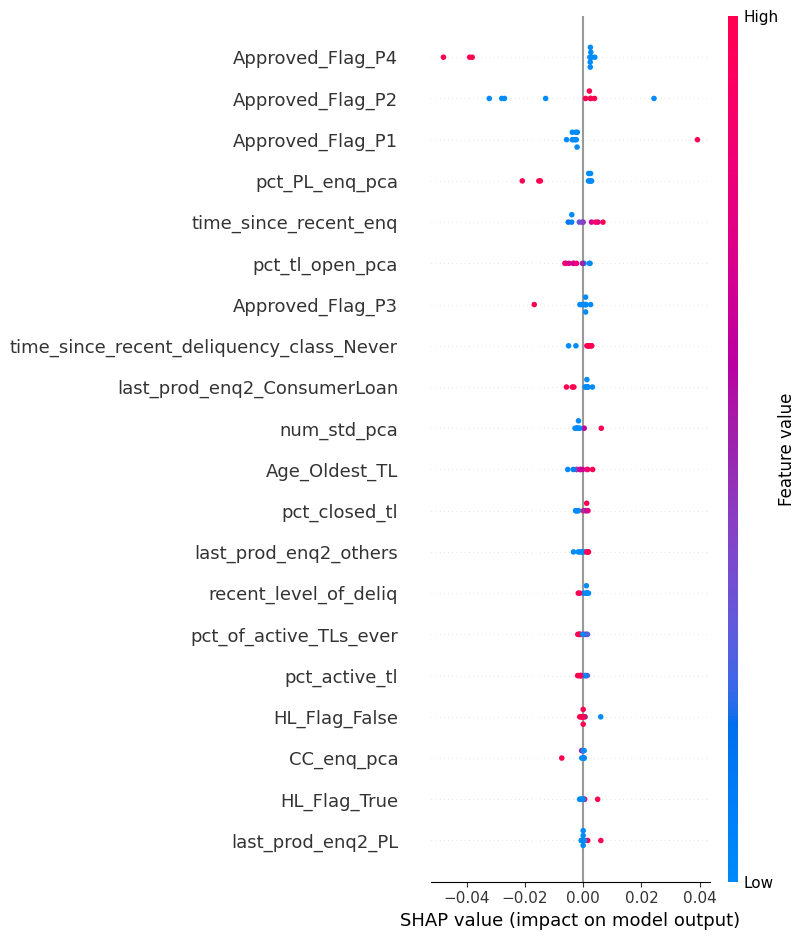

In [56]:
# Visualizar la importancia de las características (En este caso solo se representan 10 muestras)
shap.summary_plot(shap_values, X_test.iloc[0:10, :])

In [57]:
pred_vs_real(best_knn, X_test, y_test)

Predicción del modelo: 0.7129020467836258
Valor real: 0.7222222222222223


In [58]:
# Calcular RMSE y R² en el conjunto de prueba
predicciones_test = best_knn.predict(X_test)
mse_knn = mean_squared_error(y_test, predicciones_test)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, predicciones_test)

# Imprimir las métricas
print(f"RMSE: {rmse_knn}")
print(f"R²: {r2_knn}")

RMSE: 0.0302047923874413
R²: 0.7571507009080386


## 5. Árbol de Decisión

In [59]:
# Definir el rango de hiperparámetros
param_dist = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'max_depth': range(8, 17, 1),
    'min_samples_split': [10, 15, 20],
    'max_features': ['sqrt', 'log2']
}

# Crear el modelo de árbol de decisión para regresión
tree = DecisionTreeRegressor()

# Configurar GridSearchCV con validación cruzada de 3 folds
random_search = RandomizedSearchCV(
    tree, 
    param_distributions=param_dist,  
    n_iter=40,
    cv=3,
    scoring='neg_mean_squared_error',  
    n_jobs=-1,  
    random_state=29,  
    verbose=1  
)

# Ajustar el modelo en los datos de entrenamiento
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_iter=40,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'friedman_mse',
                                                      'absolute_error'],
                                        'max_depth': range(8, 17),
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_split': [10, 15, 20]},
                   random_state=29, scoring='neg_mean_squared_error',
                   verbose=1)

In [60]:
# Obtener el mejor modelo
best_tree = random_search.best_estimator_

# Mejor combinación de hiperparámetros
top_tree_params = random_search.best_params_

# Convertirlo a un DataFrame de pandas para mostrarlo de manera más limpia
df_top_params = pd.DataFrame(list(top_tree_params.items()), columns=["Hiperparámetro", "Valor"])

# Imprimir el DataFrame
print("\nMejores hiperparámetros encontrados:")
print(df_top_params)



Mejores hiperparámetros encontrados:
      Hiperparámetro         Valor
0  min_samples_split            20
1       max_features          sqrt
2          max_depth            15
3          criterion  friedman_mse


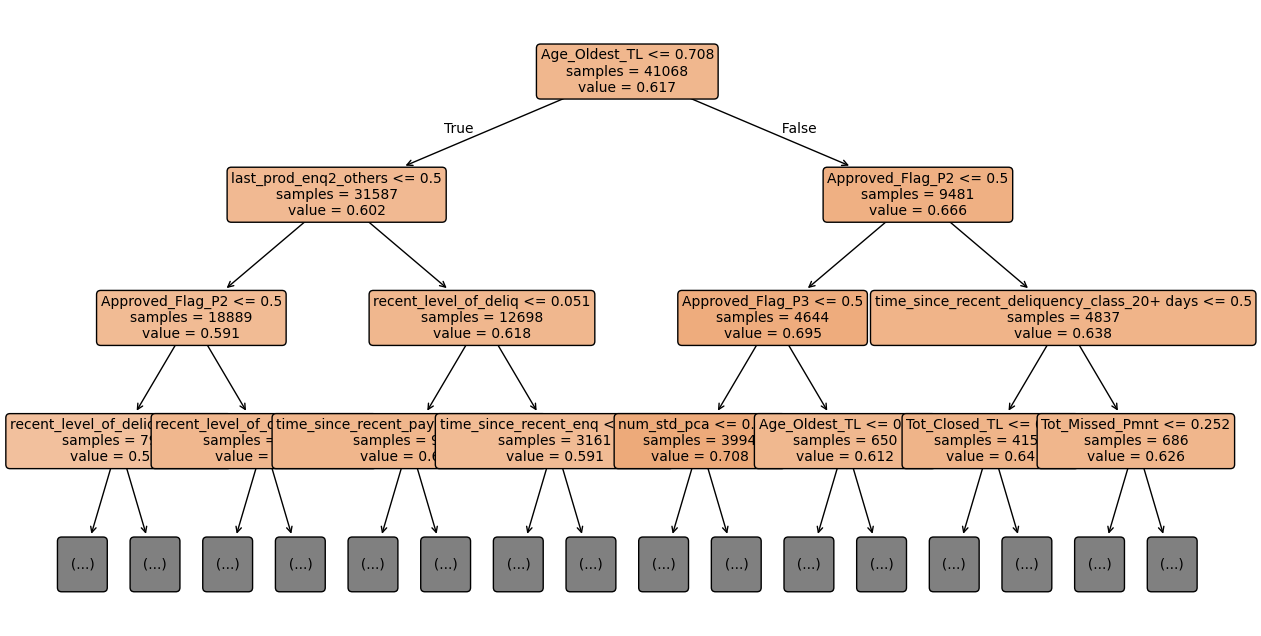

In [61]:
plt.figure(figsize=(15, 8))
plot_tree(
    best_tree, 
    feature_names=X_train.columns, 
    filled=True, 
    impurity=False, 
    rounded=True, 
    fontsize=10,
    max_depth=3
)
plt.show()

In [62]:
# Crear el explicador de SHAP para el mejor modelo de árbol de decisión
explainer = shap.TreeExplainer(
    model=best_tree,
    data=X_train,
    model_output='raw',
    feature_perturbation='interventional')

# Obtener los valores SHAP para todo el conjunto de prueba
shap_values = explainer.shap_values(X_test)

In [63]:
# Explicamos la influencia de los valores SHAP para una predicción
shap.force_plot(explainer.expected_value, shap_values[0, :], features=X_test.iloc[0, :])

In [64]:
# Explicación de predicciones para más de una muestra
shap.force_plot(explainer.expected_value, shap_values[:100, :], features=X_test.iloc[:100, :])

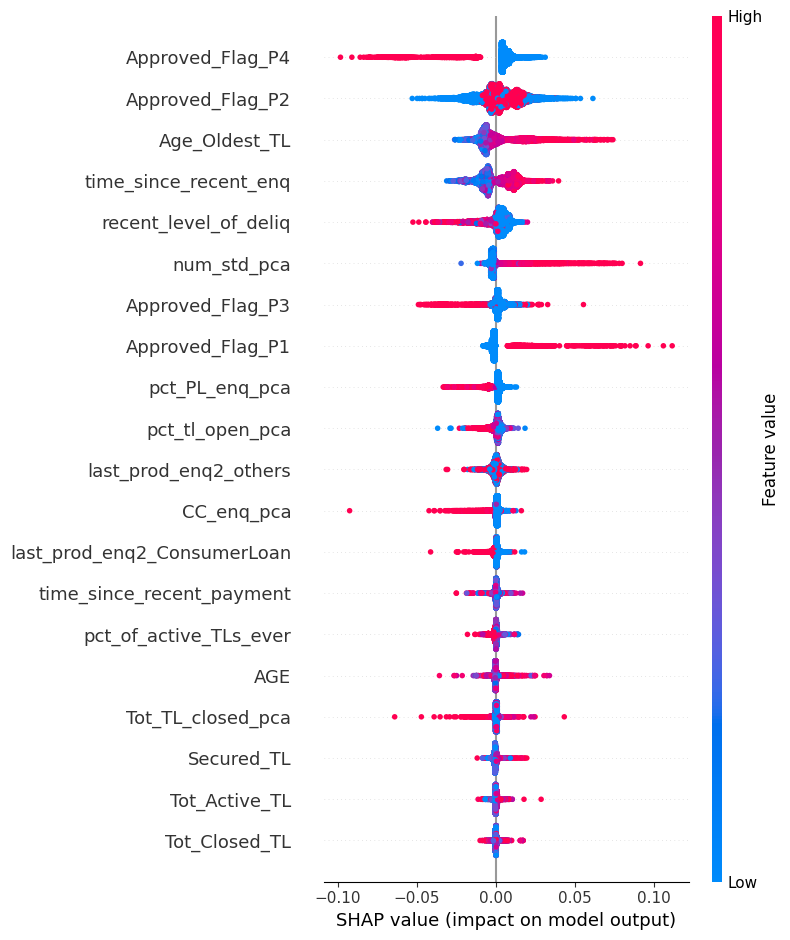

In [65]:
# Visualizar resumen la importancia de las características
shap.summary_plot(shap_values, X_test)

In [66]:
# # Filtrar características binarias (solo aquellas con más de 2 valores únicos)
# non_binary_features = [col for col in X_test.columns if X_test[col].nunique() > 2]

# # Obtener índices de las características más importantes que no sean binarias
# top_inds = np.argsort(np.abs(shap_values).mean(0))[-3:]
# top_inds = [i for i in top_inds if X_test.columns[i] in non_binary_features]

# # Graficar los valores SHAP de las características más importantes
# if len(top_inds) > 0:
#     for i in range(len(top_inds)):
#         shap.dependence_plot(top_inds[i], shap_values, features=X_test, display_features=X_test)
# else:
#     print("No hay suficientes características continuas para graficar.")

In [67]:
pred_vs_real(best_tree, X_test, y_test)

Predicción del modelo: 0.6986476608187133
Valor real: 0.7222222222222223


In [68]:
# Calcular RMSE y R² en el conjunto de prueba
predicciones_test = best_tree.predict(X_test)
mse_tree = mean_squared_error(y_test, predicciones_test)
rmse_tree = np.sqrt(mse_tree)
r2_tree = r2_score(y_test, predicciones_test)

# Imprimir las métricas
print(f"RMSE: {rmse_tree}")
print(f"R²: {r2_tree}")

RMSE: 0.02958062198752284
R²: 0.7670837723114454


## 6. XGBoost

In [70]:
# Definir el modelo
xgb = xgb.XGBRegressor(tree_method='hist', objective='reg:squarederror')

# Definir la parrilla de hiperparámetros
param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 10),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Configurar la búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=29,
    n_jobs=-1
)

# Ejecutar la búsqueda
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E195B562D0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E1AA072A10>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E195C4A890>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E1AA070610>},
                   random_state=29, scoring='neg_mean_squared_error',
                   verbose=2)

In [71]:

# Obtener el mejor modelo
best_xgb = random_search.best_estimator_

# Mejor combinación de hiperparámetros
top_xgb_params = random_search.best_params_

# Convertirlo a un DataFrame de pandas para mostrarlo de manera más limpia
df_top_params = pd.DataFrame(list(top_xgb_params.items()), columns=['Hiperparámetro', 'Valor'])

# Imprimir el DataFrame
print("\nMejores hiperparámetros encontrados:")
print(df_top_params)




Mejores hiperparámetros encontrados:
     Hiperparámetro       Valor
0  colsample_bytree    0.950587
1             gamma    0.283579
2     learning_rate    0.110462
3         max_depth    5.000000
4  min_child_weight    8.000000
5      n_estimators  801.000000
6         reg_alpha    0.296688
7        reg_lambda    0.065097
8         subsample    0.755393


In [72]:
# Crear el explicador de SHAP para el mejor modelo de árbol de decisión
explainer = shap.TreeExplainer(
    model=best_xgb,
    data=X_train,
    model_output='raw',
    feature_perturbation='interventional')

In [73]:
# Obtener los valores SHAP para todo el conjunto de prueba
shap_values = explainer.shap_values(X_test)
# Explicamos la influencia de los valores SHAP para una predicción
shap.force_plot(explainer.expected_value, shap_values[0, :], features=X_test.iloc[0, :])

 92%|==================  | 9450/10268 [00:13<00:01]       

In [74]:
# Explicación de predicciones para más de una muestra
shap.force_plot(explainer.expected_value, shap_values[:100, :], features=X_test.iloc[:100, :])

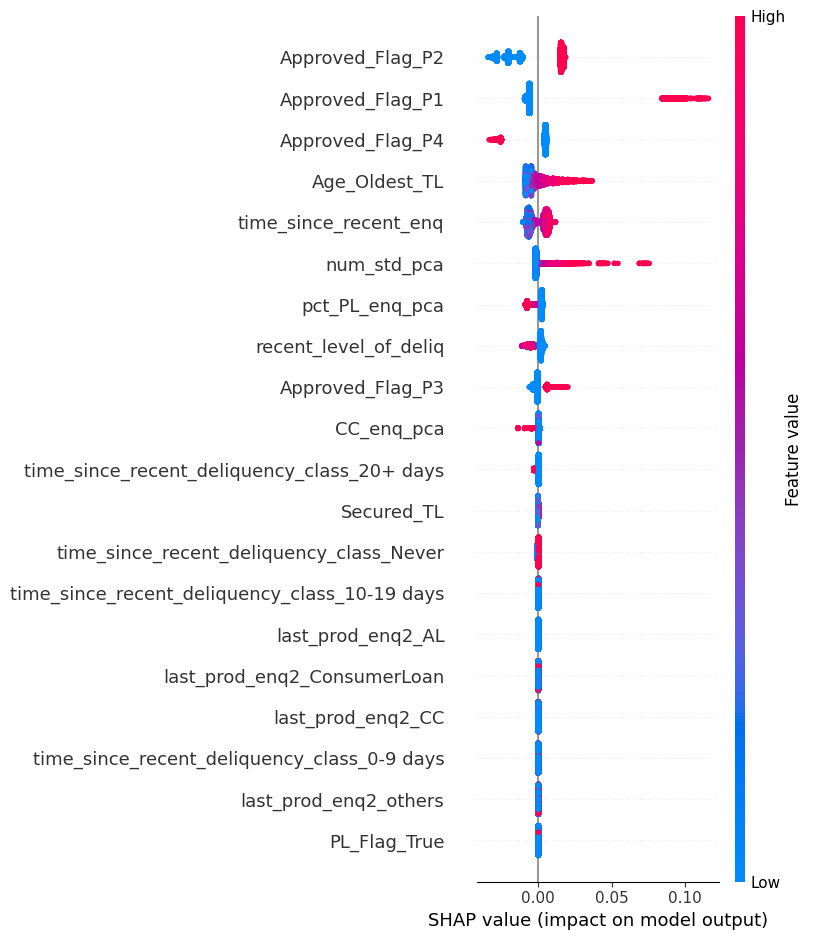

In [75]:
# Visualizar resumen la importancia de las características
shap.summary_plot(shap_values, X_test)

In [76]:

# # Filtrar características binarias (solo aquellas con más de 2 valores únicos)
# non_binary_features = [col for col in X_test.columns if X_test[col].nunique() > 2]
# # Obtener índices de las características más importantes que no sean binarias
# top_inds = np.argsort(np.abs(shap_values).mean(0))[-3:]
# top_inds = [i for i in top_inds if X_test.columns[i] in non_binary_features]

# # Graficar los valores SHAP de las características más importantes
# if len(top_inds) > 0:
#     for i in range(len(top_inds)):
#         shap.dependence_plot(top_inds[i], shap_values, features=X_test, display_features=X_test)
# else:
#     print("No hay suficientes características continuas para graficar.")

In [77]:
pred_vs_real(best_xgb, X_test, y_test)

Predicción del modelo: 0.7009536623954773
Valor real: 0.7222222222222223


In [78]:
# Calcular RMSE y R² en el conjunto de prueba
predicciones_test = best_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, predicciones_test)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, predicciones_test)

# Imprimir las métricas
print(f"RMSE: {rmse_xgb}")
print(f"R²: {r2_xgb}")

RMSE: 0.02629180037821471
R²: 0.815996621631497


## 7. SVM

In [79]:
# Definir el modelo
svr = LinearSVR()

# Definir la parrilla de hiperparámetros
param_dist = {
    'C': uniform(0.1, 10),
    'epsilon': uniform(0.01, 1),
    'max_iter': randint(100, 1000)
}

# Configurar la búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_dist,
    n_iter=200,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=29,
    n_jobs=-1
)

# Ejecutar la búsqueda
random_search.fit(X_train, y_train)

# Resultados
print("Mejores parámetros:", random_search.best_params_)
print("Mejor RMSE:", (-random_search.best_score_) ** 0.5)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Mejores parámetros: {'C': np.float64(0.1540846550502383), 'epsilon': np.float64(0.038435516617968395), 'max_iter': 679}
Mejor RMSE: 0.02588157519135975


C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [80]:
# Obtener el mejor modelo
best_svr = random_search.best_estimator_

# Mejor combinación de hiperparámetros
top_svr_params = random_search.best_params_

# Convertirlo a un DataFrame de pandas para mostrarlo de manera más limpia
df_top_params = pd.DataFrame(top_svr_params.items(), columns=['Hiperparámetro', 'Valor'])

# Imprimir el DataFrame
print("\nMejores hiperparámetros encontrados:")
print(df_top_params)


Mejores hiperparámetros encontrados:
  Hiperparámetro       Valor
0              C    0.154085
1        epsilon    0.038436
2       max_iter  679.000000


In [81]:
# Crear el explicador SHAP para SVR
explainer = shap.KernelExplainer(
    model=best_svr.predict,  # SVR necesita .predict()
    data=X_train[:100],
    link="identity"  # Relación directa entre salida y SHAP values
)

# Calcular valores SHAP para un subconjunto de datos de prueba
shap_values = explainer.shap_values(X_test[:100]) 

  0%|          | 0/100 [00:00<?, ?it/s]

In [82]:
# Explicamos la influencia de los valores SHAP para una predicción
shap.force_plot(explainer.expected_value, shap_values[0, :], features=X_test.iloc[0, :])

In [83]:
# Explicación de predicciones para más de una muestra
shap.force_plot(explainer.expected_value, shap_values[:100, :], features=X_test.iloc[:100, :])

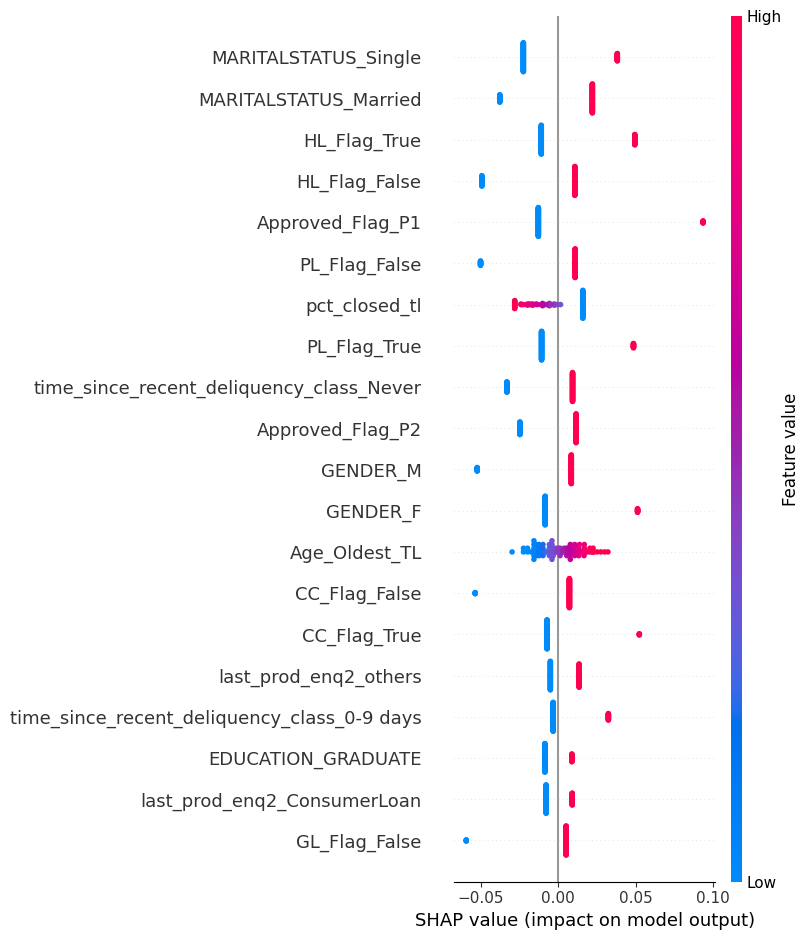

In [84]:
# Visualizar resumen la importancia de las características
shap.summary_plot(shap_values, X_test[:100])

In [85]:
pred_vs_real(best_svr, X_test, y_test)

Predicción del modelo: 0.7280333422348969
Valor real: 0.7222222222222223


In [86]:
# Calcular RMSE y R² en el conjunto de prueba
predicciones_test = best_svr.predict(X_test)
mse_svr = mean_squared_error(y_test, predicciones_test)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, predicciones_test)

# Imprimir las métricas
print(f"RMSE: {rmse_svr}")
print(f"R²: {r2_svr}")

RMSE: 0.02747636307205959
R²: 0.7990427692235995


## 8. Red Neuronal Multicapa

In [87]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler

In [88]:
# Función para el ajuste de la tasa de aprendizaje
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr  # Mantiene la tasa de aprendizaje en los primeros 10 epochs
    else:
        return lr * 0.95  # Reduce la tasa de aprendizaje en un 5% cada epoch después del 10

# Crear el modelo
rnn = Sequential()

# Capa de entrada con normalización y activación LeakyReLU
rnn.add(Input(shape=(X_train.shape[1],)))
rnn.add(Dense(256, kernel_regularizer=l2(0.005)))
rnn.add(BatchNormalization()) 
rnn.add(LeakyReLU(negative_slope=0.01))

# Capas ocultas con activación LeakyReLU y BatchNormalization
rnn.add(Dense(128, kernel_regularizer=l2(0.005)))
rnn.add(BatchNormalization())
rnn.add(LeakyReLU(negative_slope=0.01))

rnn.add(Dense(128, kernel_regularizer=l2(0.005)))
rnn.add(BatchNormalization())
rnn.add(LeakyReLU(negative_slope=0.01))

# Dropout para evitar sobreajuste
rnn.add(Dropout(0.3))

# Capa de salida (regresión)
rnn.add(Dense(1, activation="linear"))

# Compilar el modelo con el optimizador Adam
optimizer = Adam(learning_rate=0.001)
rnn.compile(optimizer=optimizer, loss="mse", metrics=["mean_squared_error"])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_callback = LearningRateScheduler(lr_scheduler)  # Agregar el scheduler

# Entrenamiento del modelo
history = rnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, 
                  batch_size=128, callbacks=[early_stopping, lr_callback])

Epoch 1/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.8749 - mean_squared_error: 1.0705 - val_loss: 1.1147 - val_mean_squared_error: 0.0176 - learning_rate: 0.0010
Epoch 2/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0064 - mean_squared_error: 0.1000 - val_loss: 0.4563 - val_mean_squared_error: 0.0088 - learning_rate: 0.0010
Epoch 3/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3924 - mean_squared_error: 0.0383 - val_loss: 0.1589 - val_mean_squared_error: 0.0057 - learning_rate: 0.0010
Epoch 4/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1366 - mean_squared_error: 0.0178 - val_loss: 0.0540 - val_mean_squared_error: 0.0053 - learning_rate: 0.0010
Epoch 5/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0480 - mean_squared_error: 0.0102 - val_loss: 0.0203 - val_mean_squared_error: 0.0043 - learning_rate: 0.0010
Epoch 6/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0204 - mean_squared_error: 0.0077 - val_loss: 0.0110 - val_mean_squared_

# ARREGLAR

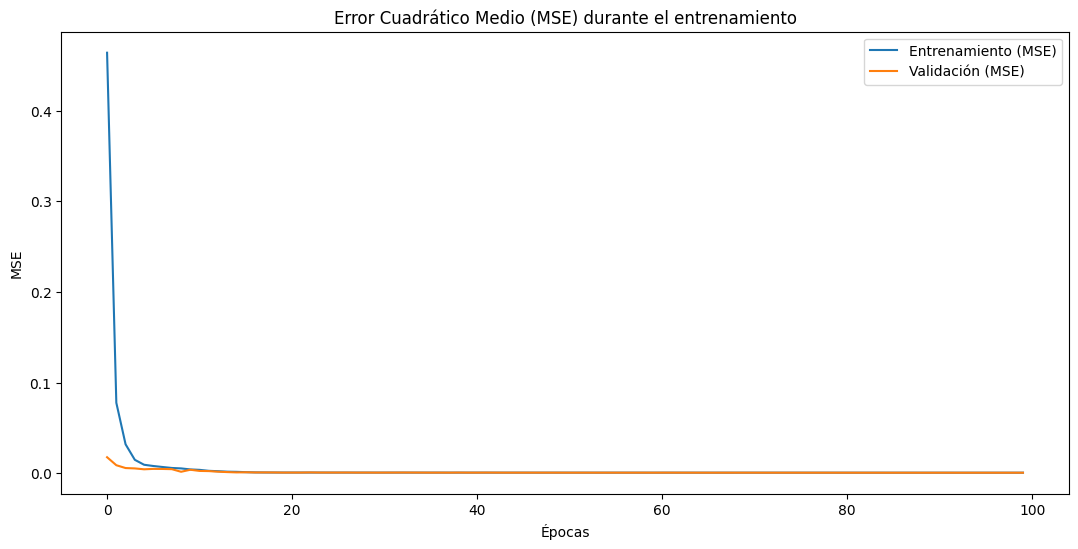

NameError: name 'result' is not defined

In [ ]:
# # Graficar los valores de error absoluto medio durante el entrenamiento
# plt.figure(figsize=(13,6))
# plt.plot(history.history['mean_squared_error'], label='Entrenamiento (MSE)')
# plt.plot(history.history['val_mean_squared_error'], label='Validación (MSE)')
# plt.title('Error Cuadrático Medio (MSE) durante el entrenamiento')
# plt.xlabel('Épocas')
# plt.ylabel('MSE')
# plt.legend()
# plt.show()

# # Función de pérdida y mse
# print(f"Loss: {result[0]}, mean_absolute_percentage_error: {result[1]}")


In [90]:
# Definir una función de predicción que reciba las características correctamente
def f(X):
    return rnn.predict(X).flatten()  # SHAP espera una salida 1D

# Crear el explicador usando un subconjunto de datos
explainer = shap.KernelExplainer(f, X_train[:50])  # Se usa una muestra pequeña para aproximación

# Calcular los valores SHAP para un conjunto de prueba
shap_values = explainer.shap_values(X_test[:10])  # Calculamos para 10 muestras

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 3s 941us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 3s 951us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 3s 929us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 3s 871us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 3s 837us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 3s 834us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3404/3404 ━━━━━━━━━━━━━━━━━━━━ 3s 858us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 3s 794us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 3s 872us/step


In [91]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0, :])


In [92]:
# Explicación de predicciones para más de una muestra
shap.force_plot(explainer.expected_value, shap_values[:100, :], features=X_test.iloc[:100, :])

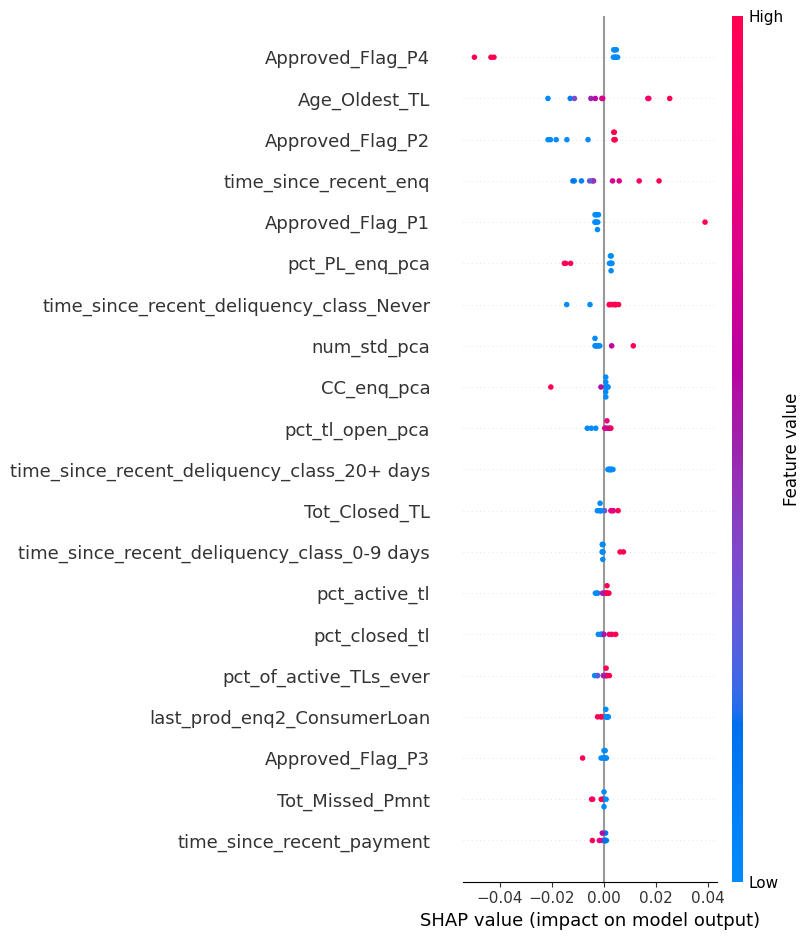

In [93]:
shap.summary_plot(shap_values, X_test[:10])

In [94]:
shap_values50 = explainer.shap_values(X.iloc[280:330, :], nsamples=500)

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32

In [95]:
pred_vs_real(rnn, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicción del modelo: [0.70210725]
Valor real: 0.7222222222222223


In [96]:
# Calcular RMSE y R² en el conjunto de prueba
predicciones_test = rnn.predict(X_test)
mse_rnn = mean_squared_error(y_test, predicciones_test)
rmse_rnn = np.sqrt(mse_rnn)
r2_rnn = r2_score(y_test, predicciones_test)                          

# Imprimir las métricas
print(f"RMSE: {rmse_rnn}")
print(f"R²: {r2_rnn}")

321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE: 0.023471034215152554
R²: 0.8533609637959014
